<a href="https://colab.research.google.com/github/antoinexp/markov-chains-COM-516/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is provided as a starting point to help you generate random instances G1 and G2 as mentioned in the handout.

You are free to use and modify it at your own convenience.

---



In [1]:
import scipy.stats as st
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
np.random.seed(36)

In [3]:
class DatasetGenerator(object):
    def __init__(self, N=100):
        self.N = N
        self.x = None
        self.v = None
        self.refresh()
  
    def refresh(self):
        raise Exception("undefined")

In [4]:
class G1(DatasetGenerator):
    def refresh(self):
        self.x = st.uniform().rvs((self.N,2))
        self.v = st.uniform().rvs((self.N,))

In [5]:
class G2(DatasetGenerator):
    def refresh(self):
        self.x = st.uniform().rvs((self.N,2))
        self.v = np.exp(st.norm(-0.85, 1.3).rvs((self.N,)))

### Uniform distribution ($\mathcal U([0,1])$) 

In [6]:
g1 = G1()

Examples:

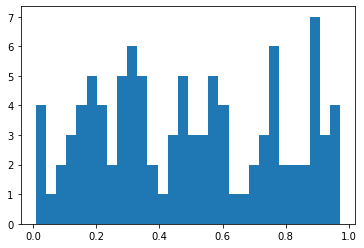

In [7]:
# Plot a histogram of the v array
plt.hist(g1.v, bins=30)
plt.show()

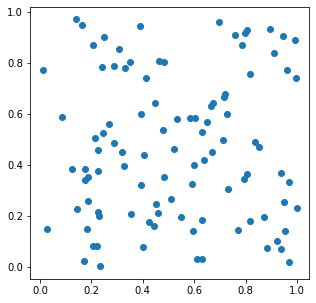

In [8]:
# plot the position of the points
plt.figure(figsize=(5,5))
plt.scatter(g1.x[:,0], g1.x[:,1])
plt.show()

You can refresh the dataset

In [9]:
g1.refresh() # generate a new dataset

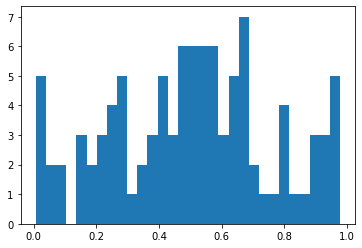

In [10]:
plt.hist(g1.v, bins=30)
plt.show()

Or for instance, you can generate 10 instances and compute the average position of all the points:

In [11]:
m = np.array([0., 0.])

for _ in range(10):
    g1.refresh() # refresh the dataset
    m  += 0.1*g1.x.mean()

print(m)

[0.50442458 0.50442458]


### Test on log-normal distribution

In [12]:
g2 = G2()

Example:

you can use g2 to generate an instance of the lognormal distribution

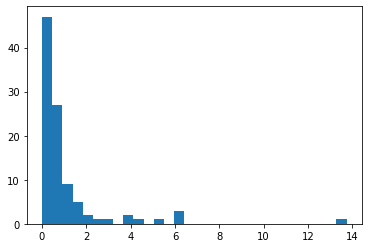

In [13]:
plt.hist(g2.v, bins=30)
plt.show()

In [14]:
g2.refresh() # to generate a new x and v

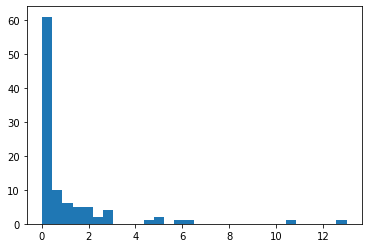

In [15]:
plt.hist(g2.v, bins=30)
plt.show()

---

### Metropolis Hastings

In [47]:
# fill-in this section with your code

In [48]:
g = g1

In [49]:
def compute_distance_matrix(points):
    '''
    Returns the matrix of pairwise squared distances between the given points.

            Parameters:
                    points (matrix (N, 2)): An array of 2d points

            Returns:
                    pairwise_distances (matrix (N, N)): The matrix of pairwise distances
    '''
    N = len(points)
    p1 = points.reshape(1, N, 2)
    p2 = points.reshape(N, 1, 2)
    return np.sum(np.square(p1 - p2), axis = 2)

In [50]:
def f(data, _lambda, selected_cities, cache):
    '''
    Evaluate the function for the selected cities
            
            Parameters:
                    data (DatasetGenerator): The cities dataset
                    _lambda (float): The lambda parameter
                    selected_cities (array (N,)): The cities that are in the subset
                    cache (matrix (N, N)): The matrix of pairwise distances

            Returns:
                    The output of the function (float): The output of the function for the given cities
    '''
    sel = selected_cities.reshape((data.N, 1)) @ selected_cities.reshape((1, data.N))
    max_squared_dist = np.max(cache[sel])
    return np.sum(data.v[selected_cities]) - _lambda * data.N * np.pi * max_squared_dist / 4

In [51]:
#To delete
def max_squared_dist2(points):
    N = len(points)
    p1 = points.reshape(1, N, 2)
    p2 = points.reshape(N, 1, 2)
    return np.max(np.sum(np.square(p1 - p2), axis = 2))

def f2(_lambda, x, v, N):
    return np.sum(v) - _lambda * N * np.pi * max_squared_dist2(x) / 4

In [52]:
%%time
#To delete
cache = compute_distance_matrix(g.x)
sel = np.ones(g.N, dtype = "bool")
l = 0.4
f(g, l, sel, cache) == f2(l, g.x[sel], g.v[sel], g.N)

Wall time: 2.96 ms


True

In [53]:
%%timeit
#To delete
f(g, l, sel, cache)

48.7 µs ± 1.39 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [54]:
%%timeit
#To delete
f2(l, g.x[sel], g.v[sel], g.N)

269 µs ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [55]:
%%time
#To delete SpeedTest
n1 = 101
n2 = 101
row, col = np.indices((n1, n2))
points = np.dstack([row, col]).flatten().reshape(n1 * n2, 2)
print(len(points))
print(np.max(compute_distance_matrix(points)))

10201
20000
Wall time: 3.88 s


In [56]:
def Metropolis_Hasting_step(data, _lambda, cache, selection, scores, remove_duplicates=True, tol=0):
    '''
    Perform one iteration of the Metropolis-Hastings algorithm
            
            Parameters:
                    data (DatasetGenerator): The cities dataset
                    _lambda (float): The lambda parameter
                    cache (matrix (N, N)): The matrix of pairwise distances
                    selection (matrix (batch_size, N)): The selected cities for all the chains
                    scores (array (batch_size,)): The scores
                    remove_duplicates (bool) : Merge the chains that are in the same state (Default : True)
                    tol (float): The tolerance to accept a move (Default : 0)

            Returns:
                    The output of the function (float): The output of the function for the given cities
    '''
    batch_size = len(selection)
    #Generate random moves for all the chains
    ind = np.random.randint(0,data.N, batch_size)
    #Convert values to a one-hot encoding
    mask = np.zeros((batch_size, data.N))
    mask[np.arange(batch_size), ind] = 1
    #cast the array to boolean
    mask = np.array(mask, dtype = "bool")
    #create all the proposal moves
    proposal = selection ^ mask
    #iterate over all chains
    for i in range(len(selection)):
        #get the proposal for the current chain
        prop = proposal[i]
        #if at least one city is selected
        if (np.sum(prop) > 0):
            #get the old score
            old_score = scores[i]
            #compute the new score
            score = f(data, _lambda, prop, cache)
            #if the move is accepted
            if score >= old_score - tol :
                #update the score and the selection
                scores[i] = score
                selection[i] = prop
    if remove_duplicates:
        #remove the duplicate chains and the associated scores
        selection, ids = np.unique(selection, return_index = True, axis = 0)
        scores = scores[ids]    
    return selection, scores

In [57]:
def is_local_max(data, _lambda, cache, selection_line, score, tol=0):
    '''
    Check whether the chain is at a local maximum or not
    This function is quite slow
            
            Parameters:
                    data (DatasetGenerator): The cities dataset
                    _lambda (float): The lambda parameter
                    cache (matrix (N, N)): The matrix of pairwise distances
                    selection_line (array (N,)): The selected cities
                    scores (float): The current score
                    tol (float): The tolerance to accept a move (Default : 0)

            Returns:
                    new_selection (matrix (<batch_size, N)): The reduced selection matrix
                    new_scores (array (<batch_size,)): The reduced scores
    '''
    #allocate a mask
    mask = np.zeros(data.N, dtype = "bool")
    #iterate all the cities
    for i in range(data.N):
        #generate a proposal
        mask[i] = True
        proposal = selection_line ^ mask
        #if at least one city is selected
        if (np.sum(proposal) > 0):
            #compute the new_score
            new_score = f(data, _lambda, proposal, cache)
            #if improvement is possible, it is not a local maximum
            if new_score >= score - tol:
                return False
        #clear the mask
        mask[i] = False
    #if we did not return yet, it is a local maximum
    return True

In [58]:
def remove_local_max(data, _lambda, cache, selection, scores, tol=0):
    '''
    Remove the chains that are in a local maximums and would reject all moves, except the best one
    This function is quite slow
            
            Parameters:
                    data (DatasetGenerator): The cities dataset
                    _lambda (float): The lambda parameter
                    cache (matrix (N, N)): The matrix of pairwise distances
                    selection (matrix (batch_size, N)): The selected cities for all the chains
                    scores (array (batch_size,)): The scores
                    tol (float): The tolerance to accept a move (Default : 0)

            Returns:
                    new_selection (matrix (<batch_size, N)): The reduced selection matrix
                    new_scores (array (<batch_size,)): The reduced scores
    '''
    #keep track of the lines to remove
    useless_lines = []
    #get the indice of the best chain
    best_chain = np.argmax(scores)
    #iterate over all chains
    for i in range(len(selection)):
        #check whether the chain is stuck or not
        is_useful = not is_local_max(data, _lambda, cache, selection[i], scores[i], data, tol = tol)
        if not (is_useful or (i == best_chain)):
            useless_lines.append(i)
    #remove the useless lines
    selection = np.delete(selection, useless_lines, axis = 0)
    scores = np.delete(scores, useless_lines, axis = 0)
    return selection, scores

In [59]:
def drop_half(selection, scores):
    '''
    Drop all the chains whose score is strictly below the median
            
            Parameters:
                    selection (matrix (batch_size, N)): The selected cities for all the chains
                    scores (array (batch_size,)): The scores

            Returns:
                    new_selection (matrix (ceil(batch_size / 2), N)): The reduced selection matrix
                    new_scores (array (ceil(batch_size / 2),)): The reduced scores
    '''
    #We keep at least one chain
    if len(scores) <= 1 :
        return selection, scores
    else :
        where = np.where(np.median(scores) <= scores)
        return selection[where], scores[where]

In [70]:
def Metropolis_Hasting(data, _lambda, cache=None, init_selection=None, plot=False, verbose_progress=False, display_result=False, batch_size=100, max_iter=1000, init_tol=0):
    '''
    Perform the Metropolis-Hastings algorithm
            
            Parameters:
                    data (DatasetGenerator): The cities dataset
                    _lambda (float): The lambda parameter
                    cache (matrix (N,N)) : The pairwise squared distance matrix (will be computed if not given) (Default : None)
                    init_selection (matrix (batch_size, N)): The starting points of the chains (Default : None, the first batch_size rows of the identity matrix)
                    plot (bool): Display the evolution of the best score and the best selection (Default : False)
                    verbose_progress (bool): Print what the algorithm is doing
                    display_result (bool): Print the results of the algorithm (Default : False)
                    batch_size (int): The number of chains we emulate (Default : 100)
                    max_iter (int): What is the number of M-H steps (Default : 1000) 
                    init_tol (float): The first value of the tolerance to accept a move (decreases over time and reaches 0 at 75% of max_iter) (Default : 0)

            Returns:
                    best_selection (array (N,)): The best state ever reached
                    best_score (float): The best_score ever reached
    '''
    
    #compute cache
    if cache is None:
        if verbose_progress :
            print("Computing the cache matrix...", end = "")
        cache = compute_distance_matrix(data.x)
    
    if verbose_progress :
        print("\rInitializing...", end = "")
    #initialize the selection
    if init_selection is not None :
        selection = init_selection
    else :
        selection = np.identity(data.N, dtype = "bool")[:batch_size]
    #initialize the score array
    scores = np.array([f(data, _lambda, selection[i], cache) for i in range(len(selection))])
    #the best score so far
    best_score = np.max(scores)
    #the best scores (over all chains) at each step
    best_scores = []
    #the iteration when the overall best was reached
    time_best_reached = 0
    #the best combination of cities
    best_selection = selection[np.argmax(scores)]
    #initialize the tolerance
    t = init_tol
    
    
    #run the algorith max_iter times
    for i in range(max_iter):
        #compute a step of the algorithm
        if verbose_progress : 
            print("\rCurrent iteration : {} Progress : {:.2f}%".format(i, i / max_iter * 100), end = "")
        selection, scores = Metropolis_Hasting_step(data, _lambda, cache, selection, scores, remove_duplicates = False, tol = t)
        
        #compute the best current score
        best = np.max(scores)
        #if there is an improvement store the new values
        if best > best_score:
            best_score = best
            time_best_reached = i
            best_selection = np.copy(selection[np.argmax(scores)])
        #keep track of the best scores
        best_scores.append(best)
        
        #update the tolerance
        t = max(t - init_tol/(0.6 * max_iter), 0)
        
    if (display_result):
        loc_max = is_local_max(data, _lambda, cache, best_selection, best_score)
        print("\r", end = "")
        print("Score : {}".format(best_score))
        print("Number of cities : {}".format(np.sum(best_selection)))
        print("Batch size : {}".format(len(scores)))
        print("Number of iterations until finding the best score = {}".format(time_best_reached))
        print("Is the best selection a local max : {}".format(loc_max))
    if (plot):
        plt.figure(figsize=(5,5))
        plt.plot(np.arange(len(best_scores)), best_scores, c = "g")
        plt.title("Evolution of the score")
        plt.xlabel("#iteration")
        plt.ylabel("Best Score")
        plt.show()
        plt.figure(figsize=(5,5))
        selected = best_selection
        plt.scatter(data.x[:,0], data.x[:,1], c = "r")
        plt.scatter(data.x[selected,0], data.x[selected,1], c = "g")
        plt.show()
    return best_selection, np.max(np.array(best_scores))

Score : 5.402023779480439rogress : 99.90%
Number of cities : 21
Batch size : 50
Number of iterations until finding the best score = 981
Is the best selection a local max : False


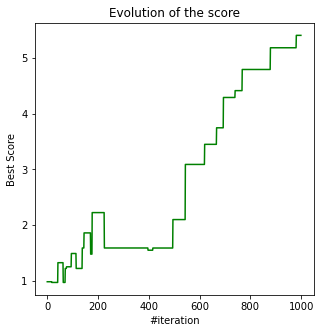

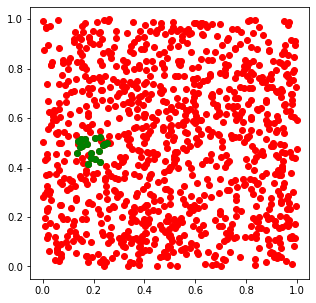

Wall time: 1min 39s


In [72]:
%%time
best_selection, best = Metropolis_Hasting(G1(1000),0.5, plot = True, verbose_progress = True, display_result = True, batch_size = 50, max_iter = 10000, init_tol = 2.5)

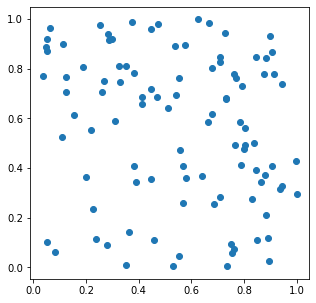

In [26]:
plt.figure(figsize=(5,5))
plt.scatter(g.x[:,0], g.x[:,1])
plt.show()

In [27]:
%%time
N = 7
minimums = []
maximums = []
means    = []
stds     = []
c_minimums = []
c_maximums = []
c_means    = []
c_stds     = []
G = g2
l_range = np.linspace(0, 2, 101)
counter = 0
for l in l_range:
    test_scores = []
    n_cities = []
    for i in range(N):
        sel, score, time_best_reached = Metropolis_Hasting(G, l, plot = False, verbose = False, batch_size = 50, max_iter = 1500, init_tol = 2.5)
        test_scores.append(score)
        n_cities.append(np.sum(sel))
        print("\rProgress : {:.3f}%".format((counter + 1) / N / len(l_range) * 100), end = "")
        counter += 1
    #print("Min  : {}".format(np.min(test_scores)))
    #print("Max  : {}".format(np.max(test_scores)))
    #print("Mean : {}".format(np.mean(test_scores)))
    #print("Std  : {}".format(np.std(test_scores)))
    minimums.append(np.min(test_scores))
    maximums.append(np.max(test_scores))
    means.append(np.mean(test_scores))
    stds.append(np.std(test_scores))
    c_minimums.append(np.min(n_cities))
    c_maximums.append(np.max(n_cities))
    c_means.append(np.mean(n_cities))
    c_stds.append(np.std(n_cities))
print("\nDone !")

Progress : 100.000%
Done !
Wall time: 1h 46min 49s


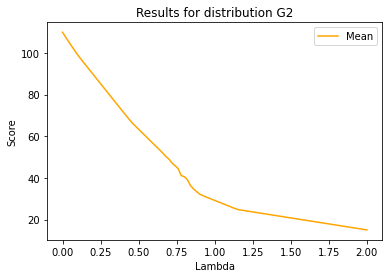

In [33]:
#plt.plot(l_range, minimums, c = "r", label = "Minimum")
#plt.plot(l_range, maximums, c = "g", label = "Maximum")
plt.plot(l_range, means, c = "orange", label = "Mean")
plt.title("Results for distribution G2")
plt.xlabel("Lambda")
plt.ylabel("Score")
plt.legend()
plt.savefig("testResultsLambdaFinerGridG2.png")
plt.show()

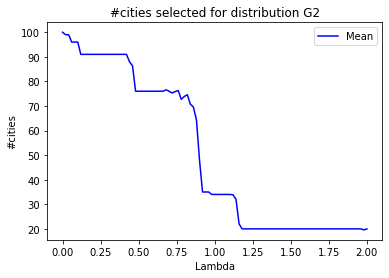

In [31]:
#plt.plot(l_range, c_minimums, c = "r", label = "Minimum")
#plt.plot(l_range, c_maximums, c = "g", label = "Maximum")
plt.plot(l_range, c_means, c = "b", label = "Mean")
plt.title("#cities selected for distribution G2")
plt.xlabel("Lambda")
plt.ylabel("#cities")
plt.legend()
plt.savefig("CitiesG2 Lambda FinerGrid.png")
plt.show()